## Liquidation Prediction on Gora Lending Data

The task of the competition is to build models which predict the likelihood and the ratio of individual liquidations, in comparison to the amount borrowed [total_liquidation_to_total_borrow].

In [109]:

import certifi
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Set the SSL CERT environment variable to ensure HTTPS requests use the correct certificate bundle
os.environ['SSL-CERT_FILE'] = certifi.where()
from giza_datasets import DatasetsLoader

# Import DatasetsLoader from giza_datasets to load the competition dataset
loader = DatasetsLoader()

# Load the training dataset from Gora competition and convert it to a pandas DataFrame
df = loader.load("gora-competition-training").to_pandas()


Dataset read from cache.
Loading dataset gora-competition-training from cache.


### Data preprocessing, Exploration, and Analysis

In [110]:
# Generate descriptive statistics that summarize the central tendency, dispersion, and shape of the dataset's distribution
df.describe()


,total_borrow,count_borrow,avg_borrow_amount,std_borrow_amount,borrow_amount_cv,total_repay,count_repay,avg_repay_amount,std_repay_amount,repay_amount_cv,...,avg_redeem_to_avg_deposit,net_deposits_to_total_deposits,net_deposits_to_total_redeemed,avg_liquidation_to_avg_borrow,dex_total_sum_added,dex_total_sum_removed,dex_total_sum_swapped,liquidated,total_liquidation_to_total_borrow,__index_level_0__
count,7.833220e+05,783322.000000,7.833220e+05,783322.000000,783322.000000,7.833220e+05,783322.000000,7.833220e+05,783322.000000,783322.000000,...,7.833220e+05,783322.000000,7.833220e+05,783322.000000,783322.0,783322.0,783322.0,783322.000000,783322.000000,7.833220e+05
mean,6.033347e+03,11.778749,2.344247e+02,242.959980,1.442197,5.550964e+03,4.115828,2.609501e+02,238.722945,0.623140,...,9.019779e+02,-113.007873,2.737097e+02,0.557274,0.0,0.0,0.0,0.215671,0.132184,5.091820e+05
std,1.680525e+05,15.245985,9.115010e+03,6109.928866,1.412328,1.614440e+05,11.088226,9.158955e+03,4696.365759,0.890489,...,4.597125e+04,6271.526552,1.602028e+04,2.453003,0.0,0.0,0.0,0.411287,0.320387,2.944697e+05
min,1.000000e-12,1.000000,1.000000e-12,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,-706950.252662,-9.999986e-01,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00
25%,6.618732e-02,1.000000,2.083023e-02,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.464784,1.145047e-01,0.000000,0.0,0.0,0.0,0.000000,0.000000,2.539652e+05
50%,1.488423e+00,6.000000,2.211536e-01,0.069441,1.225045,9.999503e-02,1.000000,4.414827e-02,0.000000,0.000000,...,6.867271e-02,0.988364,1.074616e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000,5.082325e+05
75%,1.593537e+01,20.000000,2.500000e+00,2.038590,2.233169,1.000349e+01,4.000000,1.866427e+00,0.739240,1.246357,...,1.968527e+00,1.000000,6.326215e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000,7.635108e+05
max,1.795176e+07,732.000000,1.567741e+06,696907.961050,6.751410,1.794177e+07,580.000000,1.567741e+06,404424.843263,6.629086,...,4.137916e+06,1.000000,5.213832e+06,46.797406,0.0,0.0,0.0,1.000000,5.469605,1.019888e+06


The df.describe() function is used here to provide a quick overview of the statistical summaries of the numerical columns in the DataFrame. 

In [111]:
# Count the total number of columns in the DataFrame to understand its widt
len(df.columns)

50

In [112]:
# Calculate the sum of missing values in each column to identify data completeness and integrity
df.isnull().sum()

address                              0
total_borrow                         0
count_borrow                         0
avg_borrow_amount                    0
std_borrow_amount                    0
first_borrow_date                    0
token_borrow_mode                    0
borrow_amount_cv                     0
total_repay                          0
count_repay                          0
avg_repay_amount                     0
std_repay_amount                     0
repay_amount_cv                      0
total_deposit                        0
count_deposit                        0
avg_deposit_amount                   0
std_deposit_amount                   0
deposit_amount_cv                    0
total_redeem                         0
count_redeem                         0
avg_redeem_amount                    0
std_redeem_amount                    0
redeem_amount_cv                     0
total_liquidation                    0
count_liquidation                    0
avg_liquidation_amount   

In [113]:
df.columns

Index(['address', 'total_borrow', 'count_borrow', 'avg_borrow_amount',
       'std_borrow_amount', 'first_borrow_date', 'token_borrow_mode',
       'borrow_amount_cv', 'total_repay', 'count_repay', 'avg_repay_amount',
       'std_repay_amount', 'repay_amount_cv', 'total_deposit', 'count_deposit',
       'avg_deposit_amount', 'std_deposit_amount', 'deposit_amount_cv',
       'total_redeem', 'count_redeem', 'avg_redeem_amount',
       'std_redeem_amount', 'redeem_amount_cv', 'total_liquidation',
       'count_liquidation', 'avg_liquidation_amount', 'std_liquidation_amount',
       'liquidation_amount_cv', 'days_since_first_borrow', 'net_outstanding',
       'int_paid', 'net_deposits', 'count_repays_to_count_borrows',
       'avg_repay_to_avg_borrow', 'net_outstanding_to_total_borrowed',
       'net_outstanding_to_total_repaid', 'count_redeems_to_count_deposits',
       'total_redeemed_to_total_deposits', 'avg_redeem_to_avg_deposit',
       'net_deposits_to_total_deposits', 'net_deposits_

In [114]:
import numpy as np

# Applying log transformation to the 'total_borrow' column to reduce skewness in its distribution
# The log1p function is used specifically to handle cases where total_borrow is zero (log1p(x) = log(x + 1))
df['log_total_borrow'] = np.log1p(df['total_borrow'])

# Determining the 99th percentile value of 'total_borrow' to use as a clipping threshold, 
# which helps in managing outliers by capping extreme values
clip_value = df['total_borrow'].quantile(0.99)  # Clip at the 99th percentile
df['total_borrow_clipped'] = df['total_borrow'].clip(upper=clip_value)


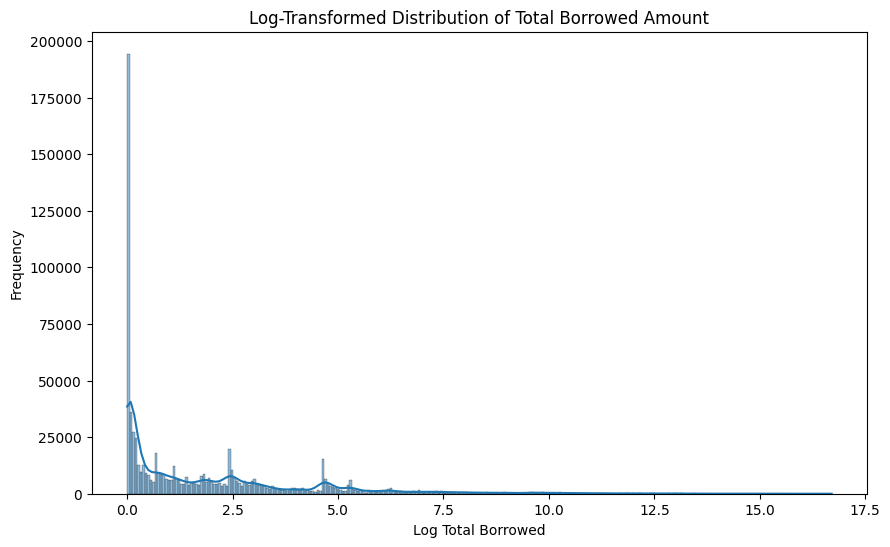

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the distribution of the log-transformed 'total_borrow' data to assess its skewness and overall spread
# The histogram is enhanced with a Kernel Density Estimate (KDE) to estimate the probability density function of the variable
plt.figure(figsize=(10, 6))
sns.histplot(df['log_total_borrow'], kde=True)
plt.title('Log-Transformed Distribution of Total Borrowed Amount')
plt.xlabel('Log Total Borrowed')
plt.ylabel('Frequency')
plt.show()

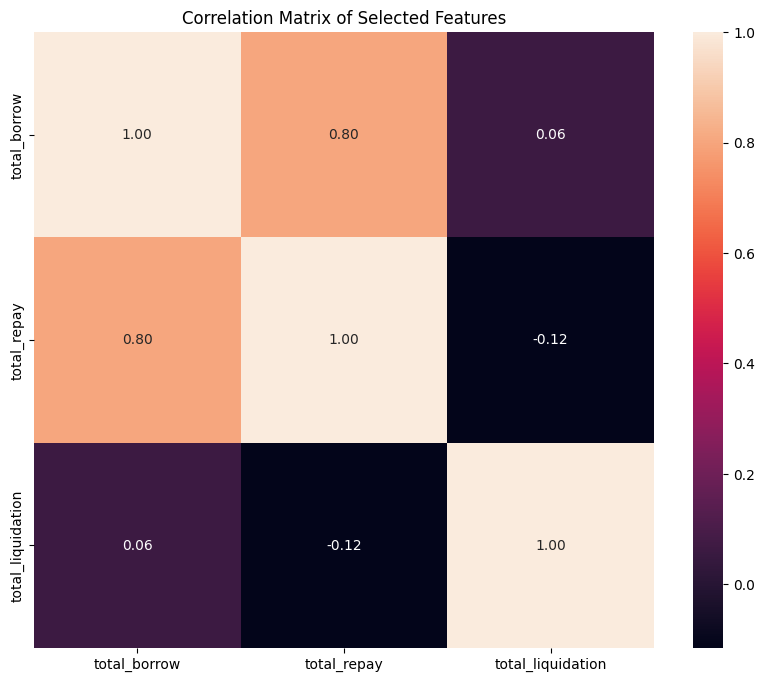

In [116]:
# Select a subset of features for visualization, focusing on total borrow, total repay, total liquidation,
features_to_plot = ['total_borrow', 'total_repay', 'total_liquidation'] + \
                   [col for col in df.columns if 'agg' in col]

# Calculate the Spearman correlation matrix for the selected features.
# Spearman correlation is used instead of Pearson as it can better handle non-linear relationships and is less sensitive to outliers.
small_corr_matrix = df[features_to_plot].corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(small_corr_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix of Selected Features')
plt.show()

In [117]:
# Identify non-numeric columns
non_numeric_cols = df.select_dtypes(include=['object', 'datetime']).columns
print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: Index(['address', 'first_borrow_date', 'token_borrow_mode', 'calc_start_time',
       'added_at'],
      dtype='object')


### Feature Engineering

In [118]:
# Convert 'first_borrow_date' to the number of days since the earliest date in the dataset
df['first_borrow_date'] = pd.to_datetime(df['first_borrow_date'])
df['days_since_first_borrow'] = (df['first_borrow_date'] - df['first_borrow_date'].min()).dt.days

# Convert 'calc_start_time' and 'added_at' to Unix timestamps
df['calc_start_time'] = pd.to_datetime(df['calc_start_time']).astype('int64') // 10**9
df['added_at'] = pd.to_datetime(df['added_at']).astype('int64') // 10**9

# Optionally, drop the original date columns if they are no longer needed
df = df.drop(columns=['first_borrow_date', 'calc_start_time', 'added_at'])

# Check the dataset to ensure the transformations were successful
print(df.head())

                                      address  total_borrow  count_borrow  \
0  0x3266424c9bee709ef24965b0ddfdc504cb382a2a     19.039084            18   
1  0xae26d5f10a1790c85b91fd79e18dd2de785d0636      0.140274             1   
2  0x38a0c07f7288872eb759534af7514960a6fcc1a5      9.020736             1   
3  0xe90fafe58deb3b262e710d43f1912c28948475c9     20.050150             1   
4  0x212944bff1143bf7d24a2f4a2d23f906483cc2fd      0.000100             1   

   avg_borrow_amount  std_borrow_amount token_borrow_mode  borrow_amount_cv  \
0           1.057727           2.268998              USDC          2.145165   
1           0.140274           0.000000              usdc          0.000000   
2           9.020736           0.000000              usdc          0.000000   
3          20.050150           0.000000              USDC          0.000000   
4           0.000100           0.000000              USDC          0.000000   

   total_repay  count_repay  avg_repay_amount  ...  \
0     0.

In [119]:
# Aggregate financial metrics by address
agg_features = df.groupby('address').agg({
    'total_borrow': ['sum', 'mean', 'std'],
    'total_repay': ['sum', 'mean', 'std'],
    'total_liquidation': ['sum', 'mean', 'std']
}).reset_index()

# Flatten the columns for easier access
agg_features.columns = ['_'.join(col).strip() for col in agg_features.columns.values]
agg_features.rename(columns={'address_': 'address'}, inplace=True)

# Print to verify the correct creation
print(agg_features.head())


                                      address  total_borrow_sum  \
0  0x00000015e180b01c40b881e10774bc784bb6f4eb         92.978891   
1  0x0000006d14ce3cf81449c3ba1f26108df0a4de8b       4682.917078   
2  0x000000df34e2422bb7744bc93ab7594d371e2d4e       1113.458554   
3  0x00000bec592ec7c143c73dc85804962075827ecc          0.051737   
4  0x0000ce08fa224696a819877070bf378e8b131acf     106265.829025   

   total_borrow_mean  total_borrow_std  total_repay_sum  total_repay_mean  \
0           1.690525               0.0         0.000000          0.000000   
1          86.720687               0.0      4600.442688         85.193383   
2          19.883188               0.0      1113.497672         19.883887   
3           0.001014               0.0         0.051737          0.001014   
4        2083.643706               0.0    105230.239790       2063.338035   

   total_repay_std  total_liquidation_sum  total_liquidation_mean  \
0         0.000000                    0.0                     0.0

In [120]:
# Display summary statistics for aggregated features
print(agg_features.describe())

# Check the top addresses by total borrowed sum
print(agg_features.sort_values(by='total_borrow_sum', ascending=False).head())


       total_borrow_sum  total_borrow_mean  total_borrow_std  total_repay_sum  \
count      1.490500e+04       1.490500e+04      1.489800e+04     1.490500e+04   
mean       3.170784e+05       6.819927e+03      9.228706e+02     2.917271e+05   
std        8.595313e+06       1.712630e+05      4.493923e+04     8.249914e+06   
min        5.580370e-11       1.052900e-12      0.000000e+00     0.000000e+00   
25%        3.992216e+00       7.672762e-02      0.000000e+00     0.000000e+00   
50%        9.462410e+01       1.822773e+00      0.000000e+00     6.801225e+00   
75%        9.611931e+02       1.936610e+01      5.211714e-04     5.440862e+02   
max        7.554302e+08       1.373509e+07      5.200294e+06     7.569295e+08   

       total_repay_mean  total_repay_std  total_liquidation_sum  \
count      1.490500e+04     1.489800e+04           1.490500e+04   
mean       6.220886e+03     8.598980e+02           2.830853e+03   
std        1.618118e+05     4.421975e+04           1.292224e+05   
mi

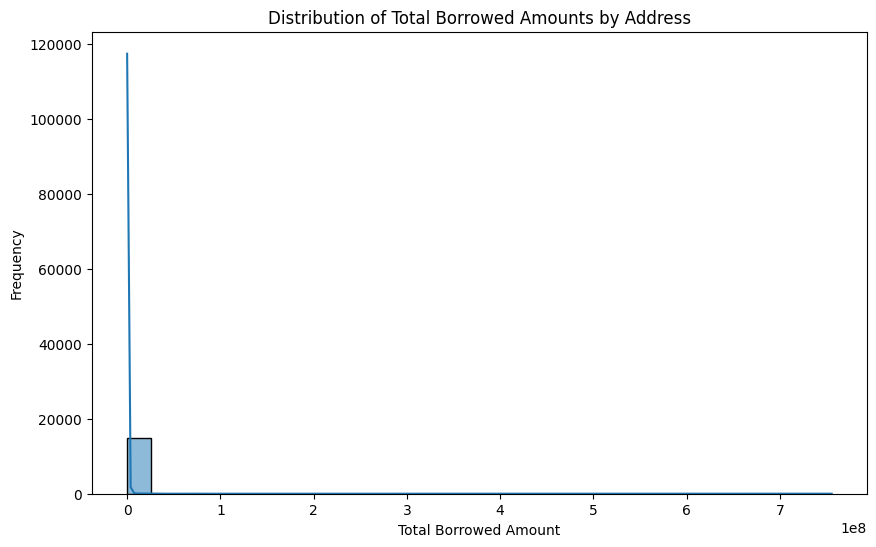

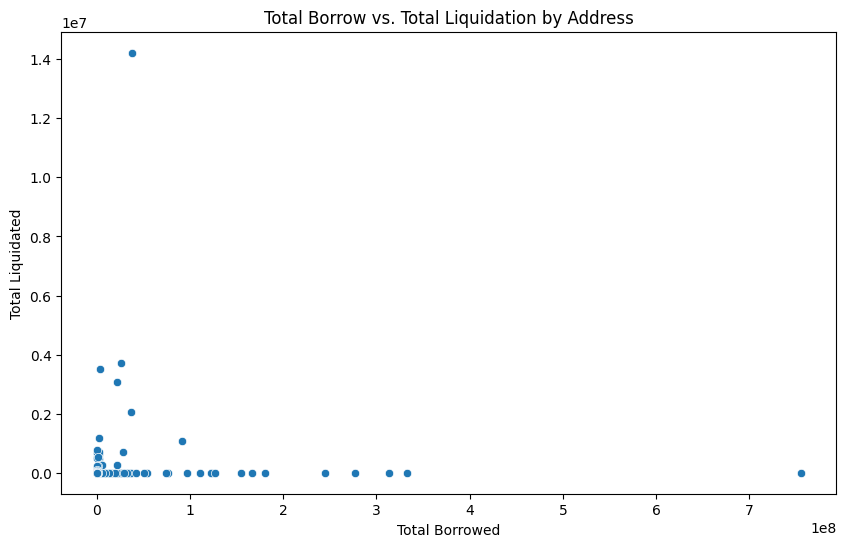

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of total borrowed sums
plt.figure(figsize=(10, 6))
sns.histplot(agg_features['total_borrow_sum'], bins=30, kde=True)
plt.title('Distribution of Total Borrowed Amounts by Address')
plt.xlabel('Total Borrowed Amount')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of total borrow vs. total liquidation
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_borrow_sum', y='total_liquidation_sum', data=agg_features)
plt.title('Total Borrow vs. Total Liquidation by Address')
plt.xlabel('Total Borrowed')
plt.ylabel('Total Liquidated')
plt.show()


In [122]:

# Decision to Drop Address
# This decision is backed by the observations that the feature does not significantly influence the predictive modeling
# due to high variability and lack of consistent patterns across different addresses
df = df.drop(columns=['address'])

# Now calculate correlation including the new 'address_freq'
numeric_df = df.select_dtypes(include=[np.number])
target_correlation = numeric_df.corr()['total_liquidation_to_total_borrow'].sort_values()
print(target_correlation) 


count_repays_to_count_borrows       -0.267454
repay_amount_cv                     -0.213669
borrow_amount_cv                    -0.212629
deposit_amount_cv                   -0.210002
count_deposit                       -0.209570
avg_repay_to_avg_borrow             -0.199731
redeem_amount_cv                    -0.190110
count_borrow                        -0.176278
count_redeems_to_count_deposits     -0.148289
log_total_borrow                    -0.143685
count_repay                         -0.119852
count_redeem                        -0.108880
total_borrow_clipped                -0.054373
avg_redeem_amount                   -0.020866
std_repay_amount                    -0.019538
std_redeem_amount                   -0.017648
total_deposit                       -0.016427
std_deposit_amount                  -0.015786
avg_deposit_amount                  -0.015633
total_redeem                        -0.014962
std_borrow_amount                   -0.014411
total_borrow                      

In [123]:
import numpy as np

# Applying log transformation to 'total_borrow' and 'total_repay' to reduce skewness.
# The log1p function is used as it applies log(1 + x), which is safe for zero values of x.
df['log_total_borrow'] = np.log1p(df['total_borrow'])
df['log_total_repay'] = np.log1p(df['total_repay'])


In [124]:


# Creating an interaction feature between 'log_total_borrow' and 'log_total_repay'
# to explore potential combined effects on the target variable. This interaction might
# capture the interdependencies between how much was borrowed and how much was repaid, 
# which could be insightful for models predicting financial behaviors or risks.
# Interaction between total borrow and total repay
df['borrow_repay_interaction'] = df['log_total_borrow'] * df['log_total_repay']


In [125]:
from sklearn.preprocessing import LabelEncoder

# Label encoding the 'token_borrow_mode' column to convert categorical token types into a numerical format.
label_encoder = LabelEncoder()
df['token_borrow_mode'] = label_encoder.fit_transform(df['token_borrow_mode'])



In [126]:
df.describe()

,total_borrow,count_borrow,avg_borrow_amount,std_borrow_amount,token_borrow_mode,borrow_amount_cv,total_repay,count_repay,avg_repay_amount,std_repay_amount,...,dex_total_sum_added,dex_total_sum_removed,dex_total_sum_swapped,liquidated,total_liquidation_to_total_borrow,__index_level_0__,log_total_borrow,total_borrow_clipped,log_total_repay,borrow_repay_interaction
count,7.833220e+05,783322.000000,7.833220e+05,783322.000000,783322.000000,783322.000000,7.833220e+05,783322.000000,7.833220e+05,783322.000000,...,783322.0,783322.0,783322.0,783322.000000,783322.000000,7.833220e+05,7.833220e+05,7.833220e+05,783322.000000,783322.000000
mean,6.033347e+03,11.778749,2.344247e+02,242.959980,28.980884,1.442197,5.550964e+03,4.115828,2.609501e+02,238.722945,...,0.0,0.0,0.0,0.215671,0.132184,5.091820e+05,1.899876e+00,6.006270e+02,1.490784,8.185846
std,1.680525e+05,15.245985,9.115010e+03,6109.928866,12.607721,1.412328,1.614440e+05,11.088226,9.158955e+03,4696.365759,...,0.0,0.0,0.0,0.411287,0.320387,2.944697e+05,2.396690e+00,3.584482e+03,2.390879,20.769115
min,1.000000e-12,1.000000,1.000000e-12,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,1.000000e-12,1.000000e-12,0.000000,0.000000
25%,6.618732e-02,1.000000,2.083023e-02,0.000000,12.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,2.539652e+05,6.408903e-02,6.618732e-02,0.000000,0.000000
50%,1.488423e+00,6.000000,2.211536e-01,0.069441,32.000000,1.225045,9.999503e-02,1.000000,4.414827e-02,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,5.082325e+05,9.116491e-01,1.488423e+00,0.095306,0.031277
75%,1.593537e+01,20.000000,2.500000e+00,2.038590,32.000000,2.233169,1.000349e+01,4.000000,1.866427e+00,0.739240,...,0.0,0.0,0.0,0.000000,0.000000,7.635108e+05,2.829404e+00,1.593537e+01,2.398213,5.836287
max,1.795176e+07,732.000000,1.567741e+06,696907.961050,53.000000,6.751410,1.794177e+07,580.000000,1.567741e+06,404424.843263,...,0.0,0.0,0.0,1.000000,5.469605,1.019888e+06,1.670320e+01,3.038913e+04,16.702642,278.987552


In [127]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [128]:
import joblib

allowed_features = [
    'log_total_borrow', 'borrow_repay_interaction', 'total_borrow_clipped',
    'count_borrow', 'avg_borrow_amount', 'std_borrow_amount', 'borrow_amount_cv', 
    'total_repay', 'count_repay', 'avg_repay_amount', 'std_repay_amount', 'repay_amount_cv',
    'total_deposit', 'count_deposit', 'avg_deposit_amount', 'std_deposit_amount',
    'deposit_amount_cv', 'total_redeem', 'count_redeem', 'avg_redeem_amount',
    'std_redeem_amount', 'redeem_amount_cv', 'days_since_first_borrow', 'net_outstanding',
    'int_paid', 'net_deposits', 'count_repays_to_count_borrows', 'avg_repay_to_avg_borrow',
    'net_outstanding_to_total_borrowed', 'net_outstanding_to_total_repaid',
    'count_redeems_to_count_deposits', 'total_redeemed_to_total_deposits',
    'avg_redeem_to_avg_deposit', 'net_deposits_to_total_deposits',
    'net_deposits_to_total_redeemed', 'dex_total_sum_added', 'dex_total_sum_removed',
    'dex_total_sum_swapped'
]

# Prepare data by filtering to allowed features only
X = df[allowed_features]
y = df['total_liquidation_to_total_borrow']







In the provided code snippet, We are employing Recursive Feature Elimination with Cross-Validation (RFECV) to methodically identify the optimal number of features for your Decision Tree Regressor model. The process involves scaling features to ensure uniformity, using RFECV to evaluate the performance of different subsets of features by minimizing RMSE, and visualizing the performance to pinpoint the number of features that yield the best cross-validation score.

Optimal number of features : 23
Best features : Index(['log_total_borrow', 'total_borrow_clipped', 'count_borrow',
       'avg_borrow_amount', 'std_borrow_amount', 'borrow_amount_cv',
       'repay_amount_cv', 'total_deposit', 'count_deposit',
       'avg_deposit_amount', 'std_deposit_amount', 'deposit_amount_cv',
       'days_since_first_borrow', 'net_outstanding', 'net_deposits',
       'count_repays_to_count_borrows', 'avg_repay_to_avg_borrow',
       'net_outstanding_to_total_borrowed', 'net_outstanding_to_total_repaid',
       'count_redeems_to_count_deposits', 'total_redeemed_to_total_deposits',
       'avg_redeem_to_avg_deposit', 'net_deposits_to_total_redeemed'],
      dtype='object')


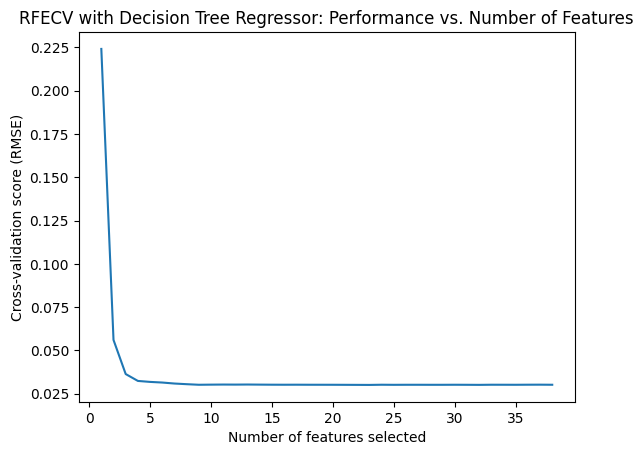

In [27]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# X and y are already defined and preprocessed

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



# Set up the estimator - here, we use a Decision Tree Regressor because it can capture nonlinear relationships
# and interactions between features.
estimator = DecisionTreeRegressor()

# Configure RFECV to use a Decision Tree Regressor to evaluate all possible numbers of features using
# k-fold cross-validation (k=5) with a goal of minimizing MSE (converted to RMSE for easier interpretation).
selector = RFECV(estimator, step=1, cv=KFold(5), scoring='neg_mean_squared_error', min_features_to_select=1)
selector.fit(X_scaled, y)

# Retrieve the mean test scores (MSE) from the cross-validation and convert them to RMSE scores
# for easier interpretation. The negative sign is corrected by negating the scores before taking the square root.
rmse_scores = np.sqrt(-selector.cv_results_['mean_test_score'])

# Results
print("Optimal number of features : %d" % selector.n_features_)
print("Best features :", X.columns[selector.support_])

# Visualizing the relationship between the number of features and the cross-validation RMSE score.
# This helps to see how model performance improves with more features and find the point of diminishing returns.
plt.figure()
plt.title("RFECV with Decision Tree Regressor: Performance vs. Number of Features")
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (RMSE)")
plt.plot(range(1, len(rmse_scores) + 1), rmse_scores)
plt.show()


Why Use a Decision Tree for RFECV: Even though the final model will be a feed-forward neural network, using a Decision Tree Regressor in the RFECV process provides a fast and effective way to identify relevant features. Decision trees are less computationally expensive compared to training preliminary neural networks and offer clear metrics on feature importance.

In [129]:
# Features selected from feature selection
selected_features = ['log_total_borrow', 'total_borrow_clipped', 'count_borrow',
       'avg_borrow_amount', 'std_borrow_amount', 'borrow_amount_cv',
       'repay_amount_cv', 'total_deposit', 'count_deposit',
       'avg_deposit_amount', 'std_deposit_amount', 'deposit_amount_cv',
       'days_since_first_borrow', 'net_outstanding', 'net_deposits',
       'count_repays_to_count_borrows', 'avg_repay_to_avg_borrow',
       'net_outstanding_to_total_borrowed', 'net_outstanding_to_total_repaid',
       'count_redeems_to_count_deposits', 'total_redeemed_to_total_deposits',
       'avg_redeem_to_avg_deposit', 'net_deposits_to_total_redeemed']

# Select the defined features and the target variable from the DataFrame
X = df[selected_features]
y = df['total_liquidation_to_total_borrow']  # Target variable

# Initialize a StandardScaler to normalize the features by removing the mean and scaling to unit variance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Scaling the features
scaler = StandardScaler()


X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [130]:
import tensorflow as tf

In [131]:
# Convert scaled data into tensors
X_train_tensor = tf.convert_to_tensor(X_train_scaled, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

# Similarly for the test set
X_test_tensor = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)


This model is designed with multiple layers and a specific activation function to process the scaled feature set effectively

In [132]:

# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_tensor.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer for regression
])


# Compile the model specifying the optimizer and loss function
# The Adam optimizer is used for its efficiency in large datasets and non-convex optimization problems
# Mean Squared Error (MSE) is chosen as the loss function because it penalizes larger errors more than smaller ones, 
# which is suitable for regression problems
model.compile(optimizer='adam', loss='mean_squared_error')


/home/kagwe/.pyenv/versions/3.11.5/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [133]:
# Fit the model to the training data
history = model.fit(
    X_train_tensor,  # Training features
    y_train_tensor,  # Training target variable
    validation_split=0.2,  # Use 20% of the training data for validation to monitor overfitting
    epochs=100,  # Number of epochs to train the model. An epoch is an iteration over the entire data provided
    batch_size=32  # Number of samples per gradient update. Smaller batch sizes typically provide a regularization effect and lower generalization error.
)



Epoch 1/100
15667/15667 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.0297 - val_loss: 0.0197
Epoch 2/100
15667/15667 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.0201 - val_loss: 0.0171
Epoch 3/100
15667/15667 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.0176 - val_loss: 0.0156
Epoch 4/100
15667/15667 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.0163 - val_loss: 0.0145
Epoch 5/100
15667/15667 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.0155 - val_loss: 0.0139
Epoch 6/100
15667/15667 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.0150 - val_loss: 0.0147
Epoch 7/100
15667/15667 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.0140 - val_loss: 0.0153
Epoch 8/100
15667/15667 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 0.0137 - val_loss: 0.0129
Epoch 9/100
15667/15667 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.0133 - val_loss: 0.0114
Epoch 10/100
15667/15667 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.0123 - val_loss: 0.0107
Epoch 11/100
15667/15667 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.0119 - val

In [134]:


# Evaluate the model on the test data
test_loss = model.evaluate(X_test_tensor, y_test_tensor)
print(f'Test MSE: {test_loss}')
rmse = np.sqrt(test_loss)
print(f'Test RMSE: {rmse}')


4896/4896 ━━━━━━━━━━━━━━━━━━━━ 5s 996us/step - loss: 0.0054
Test MSE: 0.005560641176998615
Test RMSE: 0.0745697068319208


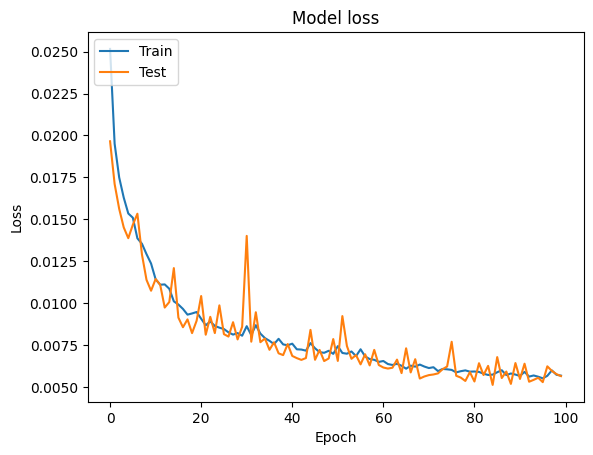

In [135]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [136]:
predictions = model.predict(X_test_tensor)

4896/4896 ━━━━━━━━━━━━━━━━━━━━ 5s 960us/step


In [137]:
def classify(ratio, threshold=0.5):
    """
    Classifies the predicted ratio into 'High Risk' or 'Low Risk' based on the threshold.
    
    Parameters:
    ratio (float): The predicted ratio from the model.
    threshold (float): The cutoff value above which risks are considered high.
    
    Returns:
    str: 'High Risk' if ratio is above the threshold, otherwise 'Low Risk'.
    """
    return "High Risk" if ratio >= threshold else "Low Risk"

# Apply classification to the predictions and actual values
predicted_classes = [classify(x) for x in predictions]
actual_classes = [classify(x) for x in y_test]


In [138]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix

precision = precision_score(actual_classes, predicted_classes, pos_label="High Risk")
accuracy = accuracy_score(actual_classes, predicted_classes)
recall = recall_score(actual_classes, predicted_classes, pos_label="High Risk")

print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")


Precision: 0.9672816728167282
Accuracy: 0.9898637219544889
Recall: 0.9551571685371423


In [139]:
model.save('final_model_100_epochs.h5')  # Saves the model architecture 


06:49:24.638 | WARNING | absl - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.

Next, we will preprocess the evaluation dataset to align with the transformations applied during the training phase, ensuring consistency in data handling. This includes scaling the features using the same scaler used for the training dataset and possibly applying other transformations like log conversion or categorical encoding. Finally, we will use the trained model to predict on this preprocessed evaluation data, allowing us to assess the model's performance on unseen data and validate its effectiveness in a real-world scenario.

In [146]:
import certifi
import os
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf

os.environ['SSL-CERT_FILE'] = certifi.where()
from giza_datasets import DatasetsLoader


loader = DatasetsLoader()
df_eval = loader.load("gora-competition-evaluation").to_pandas()


Dataset read from cache.
Loading dataset gora-competition-evaluation from cache.


In [147]:
df_eval.describe()

,total_borrow,count_borrow,avg_borrow_amount,std_borrow_amount,borrow_amount_cv,total_repay,count_repay,avg_repay_amount,std_repay_amount,repay_amount_cv,...,net_outstanding_to_total_borrowed,net_outstanding_to_total_repaid,count_redeems_to_count_deposits,total_redeemed_to_total_deposits,avg_redeem_to_avg_deposit,net_deposits_to_total_deposits,net_deposits_to_total_redeemed,dex_total_sum_added,dex_total_sum_removed,dex_total_sum_swapped
count,7.833220e+05,783322.000000,7.833220e+05,783322.000000,783322.000000,7.833220e+05,783322.000000,7.833220e+05,783322.000000,783322.000000,...,783322.000000,7.833220e+05,783322.000000,783322.000000,7.833220e+05,783322.000000,7.833220e+05,783322.0,783322.0,783322.0
mean,6.033347e+03,11.778749,2.344247e+02,242.959980,1.442197,5.550964e+03,4.115828,2.609501e+02,238.722945,0.623140,...,0.516021,8.444538e+01,0.132490,113.999304,9.019779e+02,-113.007873,2.737097e+02,0.0,0.0,0.0
std,1.680525e+05,15.245985,9.115010e+03,6109.928866,1.412328,1.614440e+05,11.088226,9.158955e+03,4696.365759,0.890489,...,0.445756,2.610067e+03,0.251204,6271.526707,4.597125e+04,6271.526552,1.602028e+04,0.0,0.0,0.0
min,1.000000e-12,1.000000,1.000000e-12,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,-706950.252662,-9.999986e-01,0.0,0.0,0.0
25%,6.618732e-02,1.000000,2.083023e-02,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.011122,3.491263e-03,0.000000,0.000000,0.000000e+00,0.464784,1.145047e-01,0.0,0.0,0.0
50%,1.488423e+00,6.000000,2.211536e-01,0.069441,1.225045,9.999503e-02,1.000000,4.414827e-02,0.000000,0.000000,...,0.527273,7.678708e-02,0.022727,0.005523,6.867271e-02,0.988364,1.074616e+00,0.0,0.0,0.0
75%,1.593537e+01,20.000000,2.500000e+00,2.038590,2.233169,1.000349e+01,4.000000,1.866427e+00,0.739240,1.246357,...,1.000000,1.465077e+00,0.166667,0.509781,1.968527e+00,1.000000,6.326215e+00,0.0,0.0,0.0
max,1.795176e+07,732.000000,1.567741e+06,696907.961050,6.751410,1.794177e+07,580.000000,1.567741e+06,404424.843263,6.629086,...,1.000000,1.142802e+06,12.000000,706951.252662,4.137916e+06,1.000000,5.213832e+06,0.0,0.0,0.0


In [148]:
len(df_eval.columns)


40

In [149]:
# Example: Log transformation
df_eval['log_total_borrow'] = np.log1p(df_eval['total_borrow'])

# Clipping
clip_value = df_eval['total_borrow'].quantile(0.99)  # Clip at the 99th percentile
df_eval['total_borrow_clipped'] = df_eval['total_borrow'].clip(upper=clip_value)

In [150]:
# Convert 'first_borrow_date' to the number of days since the earliest date in the dataset
df_eval['first_borrow_date'] = pd.to_datetime(df_eval['first_borrow_date'])
df_eval['days_since_first_borrow'] = (df_eval['first_borrow_date'] - df_eval['first_borrow_date'].min()).dt.days

# Convert 'calc_start_time' and 'added_at' to Unix timestamps
df_eval['calc_start_time'] = pd.to_datetime(df_eval['calc_start_time']).astype('int64') // 10**9
df_eval['added_at'] = pd.to_datetime(df_eval['added_at']).astype('int64') // 10**9

# Optionally, drop the original date columns if they are no longer needed
df_eval = df_eval.drop(columns=['first_borrow_date', 'calc_start_time', 'added_at'])

In [151]:
# Applying log transformation to skew-distributed features

df_eval['log_total_repay'] = np.log1p(df_eval['total_repay'])

In [152]:
# Interaction between total borrow and total repay
df_eval['borrow_repay_interaction'] = df_eval['log_total_borrow'] * df_eval['log_total_repay']

In [153]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_eval['token_borrow_mode'] = label_encoder.fit_transform(df_eval['token_borrow_mode'])


In [154]:

# Features selected from feature selection
selected_features = ['log_total_borrow', 'total_borrow_clipped', 'count_borrow',
       'avg_borrow_amount', 'std_borrow_amount', 'borrow_amount_cv',
       'repay_amount_cv', 'total_deposit', 'count_deposit',
       'avg_deposit_amount', 'std_deposit_amount', 'deposit_amount_cv',
       'days_since_first_borrow', 'net_outstanding', 'net_deposits',
       'count_repays_to_count_borrows', 'avg_repay_to_avg_borrow',
       'net_outstanding_to_total_borrowed', 'net_outstanding_to_total_repaid',
       'count_redeems_to_count_deposits', 'total_redeemed_to_total_deposits',
       'avg_redeem_to_avg_deposit', 'net_deposits_to_total_redeemed']


df_eval_features = df_eval[selected_features]


# Scaling the features
scaler_eval = joblib.load('scaler.pkl')

processed_eval_data_scaled = scaler_eval.transform(df_eval_features)

In [155]:
eval_tensor = tf.convert_to_tensor(processed_eval_data_scaled, dtype=tf.float32)

In [156]:
predictions = model.predict(eval_tensor)

24479/24479 ━━━━━━━━━━━━━━━━━━━━ 23s 954us/step


In [157]:
# Convert to DataFrame
results_df = pd.DataFrame(predictions, columns=['Predicted_Value'])

# If you have identifiers or timestamps you could add them to the DataFrame
# results_df['ID'] = data_ids
# results_df['Timestamp'] = timestamps

# Save to CSV
results_df.to_csv('predictions_100eps.csv', index=False)

In [158]:
np.save('predictions_100eps.npy', predictions)

In [159]:
import onnxmltools
from giza_actions.model import GizaModel
from giza_actions.task import task
from giza_actions.action import Action, action
import tf2onnx

In [160]:
model.output_names = ['output']
model.build(input_shape=(None, X_train_tensor.shape[1]))

In [161]:
# conversion based on the expected input shape
input_spec = [tf.TensorSpec([None, X_train_tensor.shape[1]], tf.float32, name='input')]

In [162]:
# Convert the model to ONNX format
onnx_model, _ = tf2onnx.convert.from_keras(model=model, input_signature=input_spec, opset=13)

2024-05-12 07:02:29.448293: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-12 07:02:29.448357: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 07:02:29.448471: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-05-12 07:02:29.449229: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-12 07:02:29.449261: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

In [164]:
onnx_file_path = './models/liquidation-model-100-eps.onnx'
with open(onnx_file_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

In [171]:
@task(name='Prediction with ONNX 4')
def prediction(eval_numpy):
    model = GizaModel(model_path="./models/liquidation-model-100-eps.onnx")
    result = model.predict(
        input_feed={"input": eval_numpy}, verifiable=False
    )
    return result

In [172]:
@action(name='Execution: Prediction with ONNX 4', log_prints=True)
def execution():
    eval_numpy = eval_tensor.numpy()
    unverifiable_predictions = prediction(eval_numpy)
    return unverifiable_predictions

In [173]:
unverifiable_predictions = execution()

07:03:41.361 | INFO    | prefect.engine - Created flow run 'enlightened-guppy' for flow 'Execution: Prediction with ONNX 4'

07:03:41.473 | INFO    | Flow run 'enlightened-guppy' - Created task run 'Prediction with ONNX 4-0' for task 'Prediction with ONNX 4'

07:03:41.476 | INFO    | Flow run 'enlightened-guppy' - Executing 'Prediction with ONNX 4-0' immediately...

07:03:41.979 | INFO    | Task run 'Prediction with ONNX 4-0' - Finished in state Completed()

07:03:42.019 | INFO    | Flow run 'enlightened-guppy' - Finished in state Completed()

In [174]:
# Convert to DataFrame
results_df_one = pd.DataFrame(unverifiable_predictions, columns=['unverifiable_predictions'])

# If you have identifiers or timestamps you could add them to the DataFrame
# results_df['ID'] = data_ids
# results_df['Timestamp'] = timestamps

# Save to CSV
results_df_one.to_csv('unverifiable_predictions_100eps.csv', index=False)

In [175]:
np.save('unverifiable_predictions_100eps.npy', unverifiable_predictions)

In [38]:
@task(name='Prediction with Cairo')
def prediction(data, model_id, version_id):
    # Initialize a GizaModel with model and version id.
    model = GizaModel(
        id=model_id,
        version=version_id
    )
    
    # Call the predict function. 
    #Set `verifiable` to True, and define the expecting output datatype.
    (result, request_id) = model.predict(
        input_feed={"node_input": data}, 
        verifiable=True,
        output_dtype="arr_fixed_point"
    )
    return result, request_id

In [ ]:
@action(name='Execution: Prediction with Cairo', log_prints=True)
def execution():
    data = eval_tensor.numpy()
    model_id = 590
    version_id = 2
    (result, request_id) = prediction(data, model_id, version_id)
    return result, request_id

(result, request_id) = execution()